# Notebook 4 - Introducción a la Regressión Logística

Este notebook supone que han visto videos de presentación sobre la <b>Regresión Logística</b> para preparar la clase: <br>
- https://www.youtube.com/watch?v=gNhogKJ_q7U (11 min 52)
- https://www.youtube.com/watch?v=HFswrM68yPU (12 min 37)

La regresión logística es un modelo de clasificación que es fácil de implementar y que funciona muy bien en clases linealmente separables. Es uno de los algoritmos de clasificación más utilizados en la industria. El modelo de regresión logística un modelo lineal para la clasificación binaria que puede extenderse a la clasificación multiclase mediante la técnica OvR <a href="http://mlwiki.org/index.php/One-vs-All_Classification">("One-vs-Rest")</a>. 

## 1. Preparación del dataset 'Titanic'

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Lo primero que vamos a hacer es leer en el dataset usando la función read_csv() de Pandas. Pondremos estos datos en un Pandas DataFrame, llamado "titanic", y nombraremos cada una de las columnas.

In [2]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<b>DESCRIPCIONES VARIABLES</b>

Survived - Sobrevivencia (0 = No; 1 = Sí)<br>
PClass - Pasajero Clase (1 = 1º; 2 = 2º; 3 = 3º)<br>
Name - Nombre<br>
Sex - Genero<br>
Edad - Edad<br>
SibSp - Número de hermanos/cónyuges a bordo<br>
Parch - Número de padres/hijos a bordo<br>
Tickete - Número de billete<br>
Fare - Precio del tickete<br>
Cabin - Cabina<br>
Embarked - Puerto de Embarque (C = Cherbourg; Q = Queenstown; S = Southampton)<br>

<b>Comprobación de que la variable de destino es binaria</b>

Como estamos construyendo un modelo para predecir la sobrevivencia de los pasajeros del Titanic, nuestro objetivo va a ser la variable "Survived" del dataset del Titanic. Para asegurarnos de que es una variable binaria, usemos la función countplot() de Seaborn.

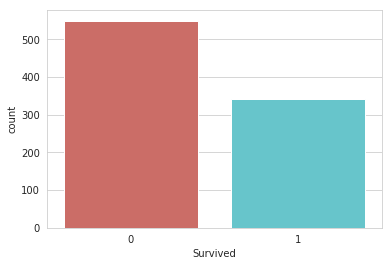

In [3]:
sb.countplot(x='Survived',data=titanic, palette='hls')

Ok, entonces vemos que la variable Survived es binaria (0 - no sobrevivió / 1 - sobrevivió)

<b>Verificación de valores que faltan</b>

Es fácil comprobar si hay valores faltantes llamando al método isull(), y el método sum() fuera de él, para devolver un recuento de todos los valores Verdaderos que son devueltos por el método isnull().

In [4]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- ¿Cuántos registros hay en el dataset?

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Ok, entonces sólo hay 891 filas en el marco de datos titánico. Cabin es casi todos los valores que faltan, así que podemos dejar esa variable completamente, pero ¿qué pasa con la edad? La edad parece ser un predictor relevante para la sobrevivencia, ¿verdad? Quisiéramos mantener las variables, pero le faltan 177 valores. Vamos a necesitar encontrar una manera de aproximar esos valores faltantes!

<b>Procesar los valores faltantes</b>

Así que sigamos adelante y saquemos del dataset todas las variables que no son relevantes para predecir la sobrevivencia. Al menos deberíamos mantener lo siguiente:

- Survived - Esta variable es obviamente relevante.<br>
- PClass - ¿Afecta la clase de un pasajero en el barco a su capacidad de sobreviviencia? <br>
- Sex - ¿Podría el género de un pasajero afectar su tasa de sobreviviencia? <br>
- Age - ¿Impacta la edad de una persona en su tasa de sobrevivencia? <br>
- SibSp - ¿El número de parientes en el barco (que son hermanos o cónyuge) afecta la sobrevivencia de una persona? <br>
- Parch - ¿El número de parientes en el barco (que son niños o padres) afecta la supervivencia de una persona? <br>
- Tarifa - ¿La tarifa que paga una persona afecta su sobrevivencia? Tal vez, conservémoslo. <br>
- Embarcado - ¿Importa el punto de embarque de una persona? Depende de cómo se llenó el barco... Vamos a conservarlo. <br>

¿Qué pasa con el nombre de una persona, el número de boleto y el número de identificación de pasajero? Son irrelevantes para predecir la supervivencia. Y como recordarán, la variable cabaña es casi todos los valores que faltan, así que podemos dejar todos estos.

In [6]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Ahora tenemos el marco de datos reducido a sólo variables relevantes, pero ahora tenemos que ocuparnos de los valores que faltan en la variable de edad.

Veamos cómo se relaciona la edad del pasajero con su clase como pasajero en el barco.


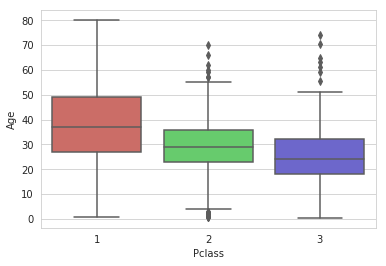

In [7]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [8]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S



Hablando a grandes rasgos, podríamos decir que cuanto más joven es un pasajero, más probable es que esté en tercera clase. Cuanto mayor sea el pasajero, mayor será la probabilidad de que esté en primera clase. Por lo tanto, existe una relación poco estrecha entre estas variables. Por lo tanto, escribamos una función que se aproxime a la edad de un pasajero, basada en su clase. Desde el punto de vista de la caja, parece que la edad media de los pasajeros de primera clase es de unos 37 años, la de los pasajeros de segunda clase es de 29 y la de los pasajeros de tercera clase es de 24 años.

Así que escribamos una función que encuentre cada valor nulo en la variable Age, y por cada nulo, verifique el valor de la Clase P y asigne un valor de edad de acuerdo a la edad promedio de los pasajeros en esa clase.

In [9]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Cuando aplicamos la función y comprobamos de nuevo los valores nulos, vemos que no hay más valores nulos en la variable edad.

In [10]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Hay 2 valores nulos en la variable embarcada. Podemos eliminar esos dos registros sin perder demasiada información importante de nuestro conjunto de datos, así que lo haremos.

In [11]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

<b>Conversión de variables categóricas en indicadores ficticios</b>

Lo siguiente que tenemos que hacer es reformatear nuestras variables para que funcionen con el modelo. Específicamente, necesitamos reformatear las variables Sexo y Embarcado en variables numéricas. 

In [12]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [13]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [14]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [15]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


<b>¡Ahora tenemos un conjunto de datos con todas las variables en el formato correcto!</b>

PREGUNTAS:<br>
- ¿De qué sirve la fase de preparación del dataset?
- ¿En qué consiste la transformación de variables categóricas en variables 'ficticias'? ¿Por qué hacemos eso? 

1) Sirve para que los datos que tomemos para hacer nuestra predicción esten completos, sean coherentes y que realmente sirvan para nuestro propocito. <br>
2) Consiste en tener todos los datos de manera numerica y que no existan errores al usarlos en alguna función

## 2. Análisis de la corelación entre variables

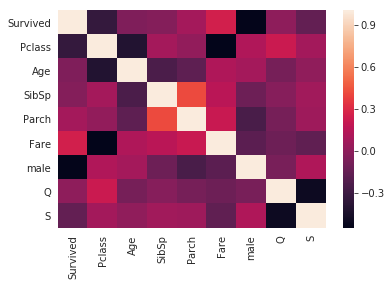

In [16]:
sb.heatmap(titanic_dmy.corr())

Fare y Pclass no son independientes el uno del otro, así que vamos a suprimir uno (Pclass por ejemplo).

In [17]:
titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,0,35.0,0,0,8.0500,1,0,1


In [18]:
titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
Survived    889 non-null int64
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
male        889 non-null uint8
Q           889 non-null uint8
S           889 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 44.3 KB


Nos quedan 889 observaciones. Es suficiente para el aprendizaje.

- PREGUNTA: ¿Por qué sacamos las variables que parecen no ser independiente de otras variables antes la fase de aprendizaje?

Porque son datos que son rebundantes por así decirlo, ya que si el boleto tiene una ratifa alta es un tanto obvio que la clase será alta, por lo tanto una lleva a la otra y viceversa.

## 3. Resolución del problema con Regresión Logística

Dividimos las columnas del dataset en dos partes: los <i>features</i> (X), y la variable que queremos predecir (y).

In [43]:
X = titanic_dmy.ix[:,(1,2,3,4,5,6,7)].values
y = titanic_dmy.ix[:,0].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [45]:
#Aprendizaje
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
print("coeficientes del modelo: "+str(LogReg.coef_))
print("intercept: "+str(LogReg.intercept_))

coeficientes del modelo: [[-0.02101435 -0.31450185 -0.18328067  0.01627129 -2.54792763 -0.66549411
  -0.39346944]]
intercept: [1.7589175]


In [47]:
#Predicciones
y_pred = LogReg.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1])

In [48]:
#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[136,  28],
       [ 35,  68]])

In [49]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.83      0.81       164
          1       0.71      0.66      0.68       103

avg / total       0.76      0.76      0.76       267



PREGUNTA:<br> 
- ¿Cómo pueden interpretar los resultados dados por la Matriz de Confusión y las métricas de Precision y Recall?
- ¿A qué corresponden los coeficientes del modelo?

1) La precision para 0 (136÷(136+35)) indica que es un 80% preciso en predecir a los pasajeros que no sobrevivieron del total de predicciones, para 1 (68÷(68+28)) indica que es un 71% preciso en predecir a los pasajeros como sobrevivientes. En cuanto al recall para 0 el 0.83 indica la cobertura, es decir que se obtuvo un 83% (136/(136+28)) de cobertura con respecto a los no sobrevivientes y un 66% (68/(68+35)) de sobrevivientes 

2) Son los valores que acompañan a cada variable de nuestro conjunto de datos.

## 4. Comparar los resultados de la Regresión Logística con kNN

PREGUNTA:
- ¿kNN es mejor que la Regresión Logística para resolver este problema? Demostrarlo con un análisis...

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

In [61]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [62]:
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [63]:
y_pred = classifier.predict(X_test)  

In [64]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[94 14]
 [25 45]]
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       108
          1       0.76      0.64      0.70        70

avg / total       0.78      0.78      0.78       178



Si analizamos nuestra matriz de confusión de kNN con respecto a la de Regresión Logistíca: el alcance y la precisión son menores, por lo tanto para este caso funciona mejor la Regresión Logistíca.

## 5. Utilizar un modelo de regresión linear para predecir la sobreviviencia

PREGUNTA:<br>
- ¿Por qué no podriamos tratar de utilizar una regresión linear para resolver el problema?

tratemos y veamos...

In [65]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [66]:
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'male', "Q", "S"]

# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

list(zip(feature_cols, linreg.coef_))

0.379746835443038
[-0.03422431 -0.04524743 -0.02450757  0.07811849 -0.25754973 -0.03213435
 -0.03845071]


[('Age', -0.03422431198171135),
 ('SibSp', -0.045247426998023324),
 ('Parch', -0.024507571194198306),
 ('Fare', 0.07811849064758579),
 ('male', -0.2575497289214239),
 ('Q', -0.03213435451351422),
 ('S', -0.03845071375044788)]

In [67]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)
y_pred

array([ 0.59355721,  0.1861567 ,  0.22020638,  0.82563225,  0.711195  ,
        0.78575944,  0.15814501,  0.18421662,  0.10534789,  0.25975064,
        0.18246679,  0.12639788,  0.72404875,  0.22678041,  0.69819262,
        0.20510294,  0.2147005 ,  0.95592517,  0.69016692,  1.05843263,
        0.18645115,  0.36120335,  0.71554226,  0.41837448,  0.15962598,
        0.7032628 ,  0.1861567 ,  0.17786618,  0.93375909,  0.15135366,
        0.27129476,  0.19282095,  0.72304333,  0.19414723,  0.20953938,
        0.28647805,  0.22375325,  0.06684372,  0.27128798,  0.16942009,
        0.7328055 ,  0.18849736,  0.718628  ,  0.17875507,  1.12062633,
        0.20433588,  0.14105242,  0.66776174,  0.50541873,  0.69875761,
        0.12427201,  0.15823618,  0.95038933,  0.15627063,  0.27368917,
        0.26332755,  0.15447778,  0.73404314,  0.86712682,  0.24383738,
        0.7237817 ,  0.13484952,  0.77997946,  0.14797077,  0.17944935,
        0.17985017,  0.26436025,  0.8204438 ,  0.77170451,  0.15

- PREGUNTA: ¿Qué pueden decir sobre las predicciones?

La regresion lineal no es aplicable para este caso por que es categorica (no continua), es decir existe un numero limidato de catergorias para la variable dependiente. Las predicciones mostradas no representan la superviviencia o no de los pasajeros (0s y 1s).

- PREGUNTA: Transformemos los valores de 'y_pred' en valores discretas (0 o 1) aplicando una regla básica tipo:
    - Si valor continua < 0.5 Entonces nueva valor = 0
    - Si valor continua >= 0.5 Entonces nueva valor = 1

In [95]:
newarray = []
for i in y_pred:
    if i < 0.5: 
        newarray.append(0)
    if i >= 0.5: 
        newarray.append(1)
newarray

[1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0]

- PREGUNTA: Analizar el rendimiento de la "regresión lineal" (ligeramente "hackeada") para resolver el problema de clasificación. Utilizar una matriz de confusión.

In [96]:
confusion_matrix = confusion_matrix(y_test, newarray)
confusion_matrix

array([[93, 15],
       [23, 47]])